In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate
import matplotlib.pyplot as plt
from slsim.image_simulation import (
    point_source_coordinate_properties,
    lens_image_series,
    rgb_image_from_image_list,
)
from slsim.Plots.plot_functions import create_image_montage_from_image_list

## Lensed quasar population

This notebook shows how to simulate lensed quasar population with variability.

In [33]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=5, unit="deg2")
full_sky_area = Quantity(value=500, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

In [3]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=None,
)

In [8]:
# Initiate deflector popiulation class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:47: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:50: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [5]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

In [34]:
# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "normal_magnitude_variance": 0.9,
}
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    light_profile=None,
    variability_model="light_curve",  # keyword for the variability model.
    kwargs_variability_model={"agn_lightcurve", "i", "g", "r"},  # specify kewords for
    agn_driving_variability_model="bending_power_law",
    agn_driving_kwargs_variability=variable_agn_kwarg_dict,
)

In [37]:
# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
    lightcurve_time=np.linspace(0, 1000, 500),
)

## Draw lenses

In [10]:
kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

## Select a lens to visualize

In [92]:
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [93]:
(
    lens_class.source.source_dict["z"],
    lens_class.einstein_radius,
    lens_class.point_source_magnitude(band="i", lensed=True),
    lens_class.deflector.magnitude("i"),
    lens_class.deflector.redshift,
)

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500


(2.957502335927517,
 1.0829565932502545,
 array([23.06302496, 24.85807181]),
 22.44047931050187,
 1.0863881572680971)

In [94]:
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=35,
    delta_pix=0.2,
    num_pix=64,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

## See the light curve of a selected quasar

In [95]:
time = np.linspace(0, 500, 500)

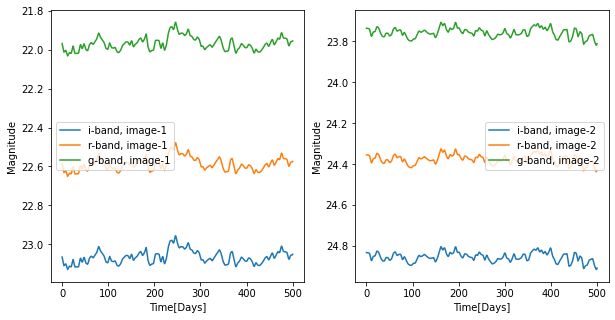

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="i", lensed=True, time=time)[0],
    label="i-band, image-1",
)
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="r", lensed=True, time=time)[0],
    label="r-band, image-1",
)
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="g", lensed=True, time=time)[0],
    label="g-band, image-1",
)
# ax1.gca().invert_yaxis()
ax1.set_ylabel("Magnitude")
ax1.set_xlabel("Time" "[Days]")
# ax1.set_xlim(0, 500)
# ax1.set_ylim(19.5, 21.25)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="i", lensed=True, time=time)[1],
    label="i-band, image-2",
)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="r", lensed=True, time=time)[1],
    label="r-band, image-2",
)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="g", lensed=True, time=time)[1],
    label="g-band, image-2",
)
# ax1.gca().invert_yaxis()
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Time" "[Days]")
# ax2.set_xlim(0, 250)
# ax2.set_ylim(None, 25)
ax2.invert_yaxis()
ax1.invert_yaxis()
ax1.legend()
ax2.legend()

## Set observation time and image configuration

In [97]:
time = np.linspace(0, 250, 10)
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = len(time)
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "/Users/narayankhadka/slsim/tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

## Simulate Image

In [98]:
# Simulate a lens image
image_lens_series_i = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_g = lens_image_series(
    lens_class=lens_class,
    band="g",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_r = lens_image_series(
    lens_class=lens_class,
    band="r",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)

In [99]:
rgb_image_list = []
for i in range(len(image_lens_series_i)):
    rgb_image_list.append(
        rgb_image_from_image_list(
            image_list=[
                image_lens_series_i[i],
                image_lens_series_r[i],
                image_lens_series_g[i],
            ],
            stretch=0.5,
        )
    )

## Visualize simulated images

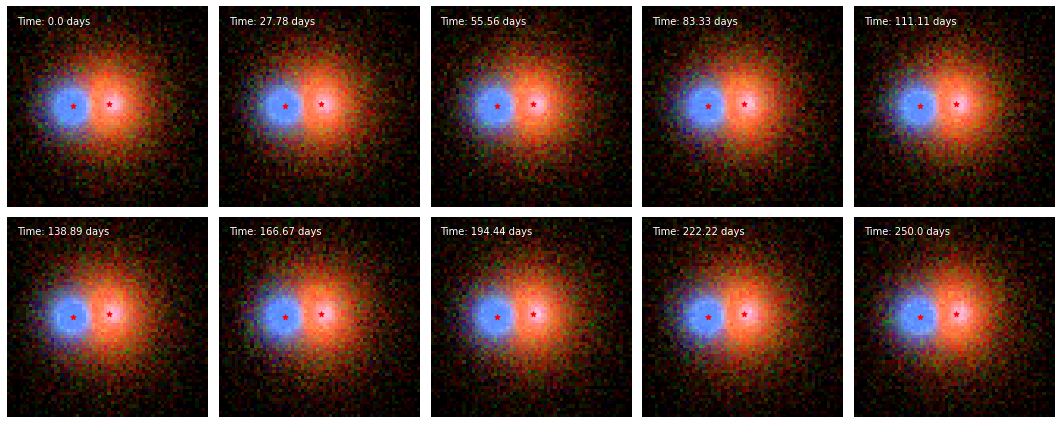

In [100]:
plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=rgb_image_list, time=time, image_center=pix_coord
)